# 04 — Cross‑lingual Semantic Framing & Narrative Divergence (2024–2025)

This notebook adds **scientifically new** analysis beyond keyword SDG tagging:

1. Cross‑lingual semantic space via multilingual sentence embeddings.
2. Unsupervised narrative clusters (topic-like) via HDBSCAN (or KMeans fallback).
3. Narrative divergence across languages via Jensen–Shannon divergence (JSD).
4. Permutation tests for significance.

**Inputs:** `data/processed/articles_tagged.*` (preferred) or `data/raw/gdelt_articles_dedup_2024_2025_*.csv`

**Outputs:** `data/processed/04_*` and `reports/figures/04_*`


In [1]:
# ---- Imports ----
import os
import re
import json
import math
import time
import hashlib
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# ---- Paths ----
PROJECT_DIR = os.path.abspath(".")
RAW_DIR = os.path.join(PROJECT_DIR, "data", "raw")
PROCESSED_DIR = os.path.join(PROJECT_DIR, "data", "processed")
FIG_DIR = os.path.join(PROJECT_DIR, "reports", "figures")
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

print("RAW_DIR:", RAW_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)
print("FIG_DIR:", FIG_DIR)


RAW_DIR: /Users/sergey/code/sdg-multilingual-media-narratives/data/raw
PROCESSED_DIR: /Users/sergey/code/sdg-multilingual-media-narratives/data/processed
FIG_DIR: /Users/sergey/code/sdg-multilingual-media-narratives/reports/figures


## Load data

Preferred input is the *tagged* dataset from Notebook 02 (`articles_tagged.*`).
If only raw/dedup CSV exists, the notebook still runs, but SDG-conditioned analysis will be limited.


In [3]:
def _read_any(path_base: str) -> pd.DataFrame:
    """Read CSV/Parquet if exists; prefers CSV for maximum compatibility."""
    csv_path = path_base + ".csv"
    pq_path = path_base + ".parquet"
    if os.path.exists(csv_path):
        return pd.read_csv(csv_path)
    if os.path.exists(pq_path):
        # use pyarrow read to avoid pandas<->pyarrow extension registry issues
        import pyarrow.parquet as pq
        return pq.read_table(pq_path).to_pandas()
    raise FileNotFoundError(f"Neither {csv_path} nor {pq_path} exists")

candidates = [
    os.path.join(PROCESSED_DIR, "articles_tagged"),
    os.path.join(PROCESSED_DIR, "articles_tagged_2024_2025"),
    os.path.join(RAW_DIR, "gdelt_articles_dedup_2024_2025_PARTIAL"),
    os.path.join(RAW_DIR, "gdelt_articles_dedup_2024_2025"),
]

df = None
for base in candidates:
    try:
        df = _read_any(base)
        print("Loaded:", base, "| shape:", df.shape)
        break
    except Exception:
        continue

if df is None:
    raise FileNotFoundError(
        "Could not find input. Expected data/processed/articles_tagged.(csv|parquet) "
        "or data/raw/gdelt_articles_dedup_2024_2025_*.csv"
    )

df.head()


Loaded: /Users/sergey/code/sdg-multilingual-media-narratives/data/processed/articles_tagged | shape: (17795, 14)


,id,url,title,snippet,seendate_utc,domain,source_country,language,gdelt_raw,collected_at_utc,text,lang,sdg_labels,n_sdgs
0,6f202b4df3957add3fa17de65672a82904d9fcb2,https://www.jutarnji.hr/vijesti/svijet/ozbiljn...,Jutarnji list - Ozbiljna kriza trese Britaniju...,NaN,2024-01-01 08:00:00+00:00,jutarnji.hr,NaN,Croatian,"{""url"": ""https://www.jutarnji.hr/vijesti/svije...",2026-01-31T10:21:12+00:00,Jutarnji list - Ozbiljna kriza trese Britaniju...,croatian,[SDG17_Partnerships],1
1,479d7917a11d10a913745b60c1d43ba23a533838,https://economy.okezone.com/read/2024/01/01/32...,Program Ganjar - Mahfud Tegaskan Ekonomi Tumbu...,NaN,2024-01-01 08:00:00+00:00,economy.okezone.com,NaN,Indonesian,"{""url"": ""https://economy.okezone.com/read/2024...",2026-01-31T10:21:12+00:00,Program Ganjar - Mahfud Tegaskan Ekonomi Tumbu...,indonesian,[SDG17_Partnerships],1
2,ce53a613efdffa49adbcbff281ed77c3b2cce8d0,https://news.yam.md/ro/story/14825507,Belgia preia de astăzi președinția rotativă a ...,NaN,2024-01-01 08:00:00+00:00,news.yam.md,NaN,Romanian,"{""url"": ""https://news.yam.md/ro/story/14825507...",2026-01-31T10:21:12+00:00,Belgia preia de astăzi președinția rotativă a ...,romanian,[SDG17_Partnerships],1
3,034d93aab57c33f94bd5d542a225af9af9d26faf,http://thepeninsulaqatar.com/article/01/01/202...,"Public , private hospitals to link records of ...",NaN,2024-01-01 08:00:00+00:00,thepeninsulaqatar.com,NaN,English,"{""url"": ""http://thepeninsulaqatar.com/article/...",2026-01-31T10:21:12+00:00,"Public , private hospitals to link records of ...",english,[SDG3_Good_Health],1
4,2666157994a9949e23d0adc9ee279c01ddaea724,https://www.oz-online.de/artikel/1431613/Neues...,Energie : Neues Heizungsgesetz tritt in Kraft ...,NaN,2024-01-01 08:00:00+00:00,oz-online.de,NaN,German,"{""url"": ""https://www.oz-online.de/artikel/1431...",2026-01-31T10:21:12+00:00,Energie : Neues Heizungsgesetz tritt in Kraft ...,german,[SDG17_Partnerships],1


## Cleaning & fields

We build a unified `text` field (`title + snippet`) and normalize languages.
If `sdg_labels` exists, we parse it into a list for SDG-conditioned analysis.


In [5]:
import numpy as np
import pandas as pd
import re
import json

def normalize_lang(x) -> str:
    # NaN/None-safe
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return "unknown"
    s = str(x).strip().lower().replace("_", "-")
    if s.startswith("zh"):
        return "zh"
    if s.startswith("en"):
        return "en"
    if s.startswith("ru"):
        return "ru"
    if s.startswith("es"):
        return "es"
    if s.startswith("fr"):
        return "fr"
    if s.startswith("de"):
        return "de"
    if s.startswith("pt"):
        return "pt"
    if s.startswith("ar"):
        return "ar"
    if s.startswith("hi"):
        return "hi"
    if s.startswith("ja"):
        return "ja"
    if s.startswith("ko"):
        return "ko"
    if not s:
        return "unknown"
    return s[:5]

def clean_text(x) -> str:
    # NaN/None-safe
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return ""
    s = str(x)
    s = s.replace("\u00a0", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def parse_labels(x):
    if isinstance(x, list):
        return [str(t) for t in x if str(t).strip()]
    if isinstance(x, str):
        xs = x.strip()
        if not xs:
            return []
        if xs.startswith("[") and xs.endswith("]"):
            try:
                arr = json.loads(xs)
                if isinstance(arr, list):
                    return [str(t) for t in arr if str(t).strip()]
            except Exception:
                pass
        return [t.strip() for t in xs.split(",") if t.strip()]
    return []

# Ensure columns exist
for col in ["title", "snippet"]:
    if col not in df.columns:
        df[col] = ""

# Clean safely (use .apply, not .astype(str).map)
df["title"] = df["title"].apply(clean_text)
df["snippet"] = df["snippet"].apply(clean_text)
df["text"] = (df["title"] + ". " + df["snippet"]).str.strip()

# Language
lang_col = "language" if "language" in df.columns else ("source_lang" if "source_lang" in df.columns else None)
df["lang"] = df[lang_col].apply(normalize_lang) if lang_col else "unknown"

# SDG labels (optional)
if "sdg_labels" in df.columns:
    df["sdg_list"] = df["sdg_labels"].apply(parse_labels)
elif "sdg" in df.columns:
    df["sdg_list"] = df["sdg"].apply(parse_labels)
else:
    df["sdg_list"] = [[] for _ in range(len(df))]

# Drop empty text
df = df[df["text"].str.len() > 0].copy()

print("After cleaning:", df.shape)
df[["lang", "title", "snippet", "sdg_list"]].head()


After cleaning: (17795, 15)


,lang,title,snippet,sdg_list
0,croat,Jutarnji list - Ozbiljna kriza trese Britaniju...,,[]
1,indon,Program Ganjar - Mahfud Tegaskan Ekonomi Tumbu...,,[]
2,roman,Belgia preia de astăzi președinția rotativă a ...,,[]
3,en,"Public , private hospitals to link records of ...",,[]
4,germa,Energie : Neues Heizungsgesetz tritt in Kraft ...,,[]


## Optional: downsample for quick iteration

Set `SAMPLE_N=None` for full runs.


In [6]:
SAMPLE_N = None  # e.g., 20000 for quick iteration
if SAMPLE_N is not None and len(df) > SAMPLE_N:
    df = df.sample(SAMPLE_N, random_state=42).reset_index(drop=True)
print("Rows:", len(df))


Rows: 17795


## Multilingual embeddings

We use `sentence-transformers`. If missing, run the pip line.
Embeddings are cached for fast reruns.


In [7]:
# If needed (run once):
# !pip install -U sentence-transformers

EMB_MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

def dataset_fingerprint(df_: pd.DataFrame) -> str:
    cols = [c for c in ["id", "url", "title"] if c in df_.columns]
    if not cols:
        cols = ["text"]
    sample = pd.concat([df_[cols].head(20), df_[cols].tail(20)], axis=0).astype(str)
    h = hashlib.sha1(sample.to_csv(index=False).encode("utf-8", errors="ignore")).hexdigest()
    return f"n{len(df_)}_{h[:10]}"

fp = dataset_fingerprint(df)
emb_path = os.path.join(PROCESSED_DIR, f"04_embeddings_{fp}.npy")
meta_path = os.path.join(PROCESSED_DIR, f"04_embeddings_{fp}.json")
print("Fingerprint:", fp)
print("Cache:", emb_path)


Fingerprint: n17795_e18598f01f
Cache: /Users/sergey/code/sdg-multilingual-media-narratives/data/processed/04_embeddings_n17795_e18598f01f.npy


In [11]:
import os, json, numpy as np

def compute_embeddings(texts: list[str], model_name: str = EMB_MODEL_NAME, batch_size: int = 64) -> np.ndarray:
    """
    Try sentence-transformers embeddings (best).
    If torch/torchvision/transformers import is broken, fall back to TF-IDF + TruncatedSVD embeddings (CPU, sklearn).
    """
    # --- Try sentence-transformers first ---
    try:
        # Avoid some transformers/torchvision edge imports by not importing anything vision-related ourselves.
        from sentence_transformers import SentenceTransformer

        model = SentenceTransformer(model_name)
        emb = model.encode(
            texts,
            batch_size=batch_size,
            show_progress_bar=True,
            normalize_embeddings=True
        )
        return np.asarray(emb, dtype=np.float32)

    except Exception as e:
        print("⚠️ sentence-transformers failed, falling back to TF-IDF+SVD embeddings.")
        print("   Original error:", repr(e))

        # --- Fallback: TF-IDF + SVD (no torch/transformers) ---
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.decomposition import TruncatedSVD
        from sklearn.preprocessing import normalize

        # Keep features bounded for speed; adjust if you want more semantic capacity.
        vec = TfidfVectorizer(
            max_features=200000,
            ngram_range=(1, 2),
            min_df=3
        )
        X = vec.fit_transform(texts)

        # 256 dims is a good balance; you can increase to 384/512 if you have RAM.
        n_components = min(256, X.shape[1] - 1) if X.shape[1] > 2 else 2
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        Z = svd.fit_transform(X).astype(np.float32)

        # normalize to mimic cosine-space embeddings
        Z = normalize(Z, norm="l2")
        return np.asarray(Z, dtype=np.float32)

# ---- Load cache or compute ----
if os.path.exists(emb_path) and os.path.exists(meta_path):
    emb = np.load(emb_path)
    print("Loaded cached embeddings:", emb.shape)
else:
    texts = df["text"].astype(str).tolist()
    emb = compute_embeddings(texts, model_name=EMB_MODEL_NAME, batch_size=batch_size if "batch_size" in globals() else 64)

    np.save(emb_path, emb)
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(
            {
                "model": EMB_MODEL_NAME,
                "fingerprint": fp,
                "shape": list(emb.shape),
                "note": "Used sentence-transformers if available; otherwise TF-IDF+SVD fallback."
            },
            f,
            indent=2
        )
    print("Computed + cached embeddings:", emb.shape)


⚠️ sentence-transformers failed, falling back to TF-IDF+SVD embeddings.
   Original error: ModuleNotFoundError("Could not import module 'PreTrainedModel'. Are this object's requirements defined correctly?")
Computed + cached embeddings: (17795, 256)


## 2D reduction (UMAP preferred; PCA fallback)


In [13]:
def reduce_2d(emb: np.ndarray, random_state: int = 42) -> np.ndarray:
    try:
        import umap
        reducer = umap.UMAP(
            n_components=2,
            n_neighbors=15,
            min_dist=0.05,
            metric="cosine",
            random_state=random_state,
        )
        return reducer.fit_transform(emb)
    except Exception:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2, random_state=random_state)
        return pca.fit_transform(emb)

xy = reduce_2d(emb)
print("xy:", xy.shape)


xy: (17795, 2)


## Narrative clusters (HDBSCAN preferred; KMeans fallback)


In [14]:
def cluster_embeddings(emb: np.ndarray, min_cluster_size: int = 60, random_state: int = 42):
    try:
        import hdbscan
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            metric="euclidean",
            cluster_selection_method="eom",
        )
        labels = clusterer.fit_predict(emb)
        return labels, "hdbscan"
    except Exception:
        from sklearn.cluster import KMeans
        k = max(10, min(60, int(len(emb) ** 0.5)))
        km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        labels = km.fit_predict(emb)
        return labels, f"kmeans_k{k}"

CLUSTER_MIN_SIZE = 60
labels, cluster_method = cluster_embeddings(emb, min_cluster_size=CLUSTER_MIN_SIZE)
df["cluster"] = labels
print("Cluster method:", cluster_method)
df["cluster"].value_counts().head(10)


Cluster method: kmeans_k60


cluster
9     4742
4     1022
2     1016
5      972
23     935
26     769
58     572
56     315
6      262
35     254
Name: count, dtype: int64

## Cluster interpretability via TF‑IDF top terms


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

def top_terms_by_cluster(df_: pd.DataFrame, topn: int = 12) -> pd.DataFrame:
    vec = TfidfVectorizer(max_features=50000, ngram_range=(1, 2), min_df=5, stop_words="english")
    X = vec.fit_transform(df_["text"].astype(str))
    vocab = np.array(vec.get_feature_names_out())

    rows = []
    for cl in sorted(df_["cluster"].unique()):
        idx = np.where(df_["cluster"].values == cl)[0]
        if len(idx) < 20:
            continue
        mean = np.asarray(X[idx].mean(axis=0)).ravel()
        top = mean.argsort()[::-1][:topn]
        rows.append({"cluster": int(cl), "n": int(len(idx)), "top_terms": ", ".join(vocab[top])})

    return pd.DataFrame(rows).sort_values("n", ascending=False)

cluster_terms = top_terms_by_cluster(df)
cluster_terms.head(20)


,cluster,n,top_terms
9,9,4742,"new, news, poverty, 2024, united, says, school..."
4,4,1022,"new, calls, women, 2024, funding, solar, counc..."
2,2,1016,"state, state union, union, women, new, 2024, a..."
5,5,972,"2024, new, county, women, india, poverty, 2023..."
23,23,935,"world, united, country, news, new, industry, w..."
26,26,769,"health, public, public health, health care, me..."
58,58,572,"climate change, climate, change, study, new, f..."
56,56,315,"la, para, en, el, las, méxico, por, que, millo..."
6,6,262,"el, en, en el, la, por, mundo, el mundo, del, ..."
35,35,254,"energy, clean, clean energy, solar, solar ener..."


## Plot semantic map by language (sanity check)


'/Users/sergey/code/sdg-multilingual-media-narratives/reports/figures/04_semantic_map_by_language.png'

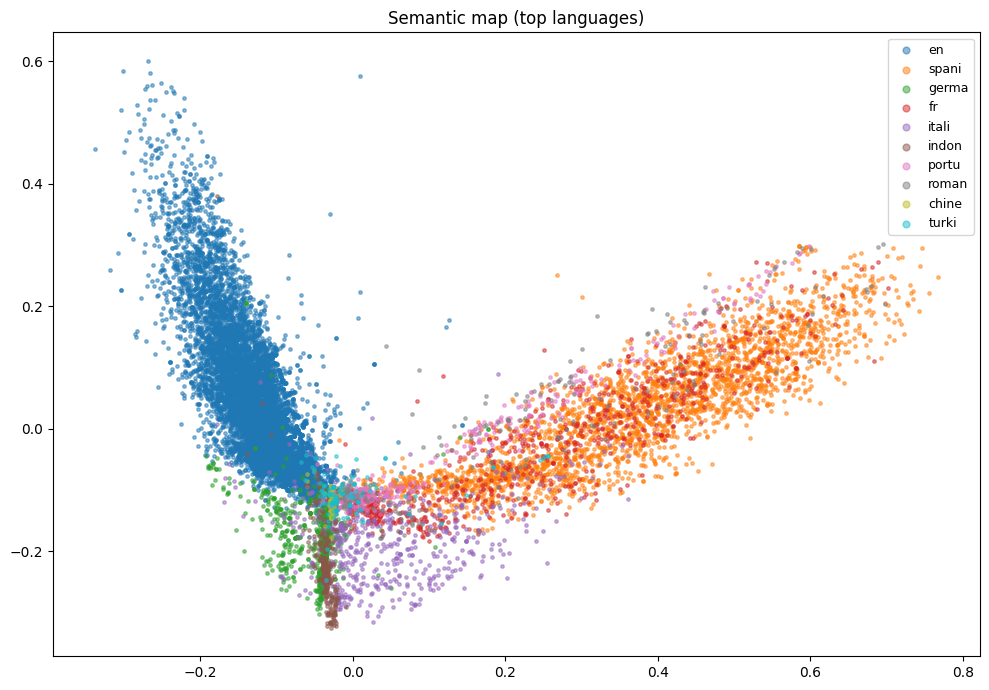

In [16]:
plt.figure(figsize=(10, 7))
langs = df["lang"].value_counts().head(10).index.tolist()
mask = df["lang"].isin(langs)

for lang in langs:
    idx = mask & (df["lang"] == lang)
    plt.scatter(xy[idx, 0], xy[idx, 1], s=6, alpha=0.5, label=lang)

plt.legend(markerscale=2, fontsize=9)
plt.title("Semantic map (top languages)")
plt.tight_layout()

fig_path = os.path.join(FIG_DIR, "04_semantic_map_by_language.png")
plt.savefig(fig_path, dpi=200)
fig_path


## Narrative divergence across languages (Jensen–Shannon divergence)


In [17]:
def js_divergence(p: np.ndarray, q: np.ndarray, eps: float = 1e-12) -> float:
    p = np.asarray(p, dtype=float) + eps
    q = np.asarray(q, dtype=float) + eps
    p = p / p.sum()
    q = q / q.sum()
    m = 0.5 * (p + q)
    kl_pm = np.sum(p * np.log(p / m))
    kl_qm = np.sum(q * np.log(q / m))
    return float(0.5 * (kl_pm + kl_qm))

clusters = np.sort(df["cluster"].unique())
langs = df["lang"].value_counts().head(20).index.tolist()

def lang_cluster_dist(df_: pd.DataFrame, lang: str, clusters_: np.ndarray) -> np.ndarray:
    sub = df_[df_["lang"] == lang]
    counts = sub["cluster"].value_counts()
    vec = np.array([counts.get(c, 0) for c in clusters_], dtype=float)
    if vec.sum() == 0:
        return vec
    return vec / vec.sum()

rows = []
for i, a in enumerate(langs):
    pa = lang_cluster_dist(df, a, clusters)
    for b in langs[i+1:]:
        pb = lang_cluster_dist(df, b, clusters)
        rows.append({"lang_a": a, "lang_b": b, "jsd": js_divergence(pa, pb)})

jsd_df = pd.DataFrame(rows).sort_values("jsd", ascending=False)
jsd_df.head(20)


,lang_a,lang_b,jsd
116,roman,alban,0.693147
128,chine,catal,0.693147
170,catal,finni,0.693147
162,alban,catal,0.693147
123,roman,greek,0.693147
115,roman,ru,0.693147
122,roman,polis,0.693147
174,catal,greek,0.693147
155,ru,catal,0.693147
173,catal,polis,0.693147


## SDG-conditioned divergence (if labels exist)


In [18]:
has_sdg = df["sdg_list"].map(len).sum() > 0
print("Has SDG labels:", has_sdg)

sdg_jsd = pd.DataFrame()
if has_sdg:
    long = df[["id", "lang", "cluster", "sdg_list"]].explode("sdg_list").rename(columns={"sdg_list": "sdg"})
    long = long[long["sdg"].notna() & (long["sdg"].astype(str).str.len() > 0)].copy()
    long["sdg"] = long["sdg"].astype(str)

    sdg_counts = long["sdg"].value_counts()
    top_sdgs = sdg_counts.head(15).index.tolist()
    print("Top SDGs:", top_sdgs)

    out_rows = []
    for sdg in top_sdgs:
        sub = long[long["sdg"] == sdg]
        clusters_s = np.sort(sub["cluster"].unique())
        langs_s = sub["lang"].value_counts().head(12).index.tolist()

        for i, a in enumerate(langs_s):
            ca = sub[sub["lang"] == a]["cluster"].value_counts()
            pa = np.array([ca.get(c, 0) for c in clusters_s], dtype=float)
            for b in langs_s[i+1:]:
                cb = sub[sub["lang"] == b]["cluster"].value_counts()
                pb = np.array([cb.get(c, 0) for c in clusters_s], dtype=float)
                if pa.sum() == 0 or pb.sum() == 0:
                    continue
                out_rows.append({
                    "sdg": sdg,
                    "lang_a": a,
                    "lang_b": b,
                    "jsd": js_divergence(pa, pb),
                    "n_a": int(pa.sum()),
                    "n_b": int(pb.sum()),
                })

    sdg_jsd = pd.DataFrame(out_rows).sort_values(["sdg", "jsd"], ascending=[True, False])
    sdg_jsd.head(30)


Has SDG labels: False


## Permutation test (significance of divergence)


In [19]:
def permutation_test_jsd(sub: pd.DataFrame, lang_a: str, lang_b: str, clusters_s: np.ndarray, iters: int = 300, seed: int = 42):
    rng = np.random.default_rng(seed)

    a = sub[sub["lang"] == lang_a]["cluster"].values
    b = sub[sub["lang"] == lang_b]["cluster"].values
    na, nb = len(a), len(b)
    if na < 50 or nb < 50:
        return None

    ca = pd.Series(a).value_counts()
    cb = pd.Series(b).value_counts()
    pa = np.array([ca.get(c, 0) for c in clusters_s], dtype=float)
    pb = np.array([cb.get(c, 0) for c in clusters_s], dtype=float)
    obs = js_divergence(pa, pb)

    pool = np.concatenate([a, b])
    stats = []
    for _ in range(iters):
        rng.shuffle(pool)
        a2 = pool[:na]
        b2 = pool[na:]
        ca2 = pd.Series(a2).value_counts()
        cb2 = pd.Series(b2).value_counts()
        pa2 = np.array([ca2.get(c, 0) for c in clusters_s], dtype=float)
        pb2 = np.array([cb2.get(c, 0) for c in clusters_s], dtype=float)
        stats.append(js_divergence(pa2, pb2))

    stats = np.array(stats)
    pval = float((np.sum(stats >= obs) + 1) / (len(stats) + 1))
    return {"obs_jsd": float(obs), "p_value": pval, "iters": int(iters), "na": int(na), "nb": int(nb)}

perm_df = pd.DataFrame()
if has_sdg and not sdg_jsd.empty:
    focus_sdg = sdg_jsd["sdg"].value_counts().index[0]
    sub = long[long["sdg"] == focus_sdg]
    clusters_s = np.sort(sub["cluster"].unique())
    pairs = sdg_jsd[sdg_jsd["sdg"] == focus_sdg].head(5)

    results = []
    for _, r in pairs.iterrows():
        res = permutation_test_jsd(sub, r["lang_a"], r["lang_b"], clusters_s, iters=300)
        if res:
            results.append({"sdg": focus_sdg, "lang_a": r["lang_a"], "lang_b": r["lang_b"], **res})

    perm_df = pd.DataFrame(results).sort_values("p_value")
perm_df


""


## Save outputs


In [20]:
out_cluster_terms = os.path.join(PROCESSED_DIR, "04_cluster_terms.csv")
out_jsd = os.path.join(PROCESSED_DIR, "04_language_pairwise_jsd.csv")
out_sdg_jsd = os.path.join(PROCESSED_DIR, "04_sdg_language_pairwise_jsd.csv")
out_perm = os.path.join(PROCESSED_DIR, "04_permutation_tests.csv")
out_report = os.path.join(PROCESSED_DIR, "04_run_report.json")

cluster_terms.to_csv(out_cluster_terms, index=False)
jsd_df.to_csv(out_jsd, index=False)
if has_sdg:
    sdg_jsd.to_csv(out_sdg_jsd, index=False)
if not perm_df.empty:
    perm_df.to_csv(out_perm, index=False)

report = {
    "created_at": datetime.utcnow().isoformat() + "Z",
    "embedding_model": EMB_MODEL_NAME,
    "cluster_method": cluster_method,
    "cluster_min_size": CLUSTER_MIN_SIZE,
    "n_rows": int(len(df)),
    "n_langs": int(df["lang"].nunique()),
    "has_sdg": bool(has_sdg),
    "outputs": {
        "cluster_terms": out_cluster_terms,
        "jsd": out_jsd,
        "sdg_jsd": out_sdg_jsd if has_sdg else None,
        "perm_tests": out_perm if (not perm_df.empty) else None,
        "semantic_map": os.path.join(FIG_DIR, "04_semantic_map_by_language.png"),
    },
}

with open(out_report, "w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)

print("Saved outputs:")
for k, v in report["outputs"].items():
    if v:
        print(" -", k, "=>", v)

out_report


Saved outputs:
 - cluster_terms => /Users/sergey/code/sdg-multilingual-media-narratives/data/processed/04_cluster_terms.csv
 - jsd => /Users/sergey/code/sdg-multilingual-media-narratives/data/processed/04_language_pairwise_jsd.csv
 - semantic_map => /Users/sergey/code/sdg-multilingual-media-narratives/reports/figures/04_semantic_map_by_language.png


/var/folders/48/64q17bwx0vj129s9_p6bxt400000gn/T/ipykernel_23893/3188941631.py:15: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.utcnow().isoformat() + "Z",


'/Users/sergey/code/sdg-multilingual-media-narratives/data/processed/04_run_report.json'